# **SEGUNDA ENTREGA: APRENDIZAJE NO SUPERVISADO**

**Autor:** Miguel Angel Rojas Torres
--
**Dataset:** `https://www.kaggle.com/datasets/arjunbhasin2013/ccdata`
--
**Repositorio:** `https://github.com/MiguelAngelRjTr/Entrega-2-Aprendizaje-Automatico-II.git`
- - - - - - - - - - 

## **1. IMPORTACIONES Y CONFIGURACIÓN GENERAL**

In [1]:
%matplotlib inline
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from ydata_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

#Lectura del dataset
df = pd.read_csv("../data/CC_GENERAL.csv")

## **2. Comprensión de los datos**

### 2.1 Contexto y objetivo

El objetivo de este proyecto es identificar segmentos naturales de clientes de tarjeta de crédito a partir de variables de comportamiento financiero, empleando técnicas de clustering y reducción de dimensionalidad. Dado que no existen etiquetas, el análisis se centra en descubrir estructura latente y obtener clusters interpretables y accionables.

### 2.2 Descripción del dataset

El dataset *CC_GENERAL* contiene información numérica agregada de clientes que usan tarjetas de crédito, incluyendo:

- Saldo y frecuencia de uso.
- Volumen y tipo de compras.
- Anticipos de efectivo.
- Pagos realizados.
- Límite de crédito.
- Antigüedad del cliente.

Cada fila representa un cliente, y las variables reflejan su comportamiento durante un periodo de observación. A continuación se presenta una visualización general.

##

In [2]:
# Visualización inicial de los datos
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### 2.2 Resumen de las variables

El dataset *CC GENERAL* contiene **18 variables**, donde cada fila representa un cliente y sus métricas agregadas de comportamiento financiero. La mayoría de características son cuantitativas continuas (saldos, pagos, volumen de compras), aunque también aparecen variables discretas asociadas a recuentos de transacciones (`*_TRX`) y variables acotadas en el rango [0,1] que representan frecuencias de uso (`*_FREQUENCY`). En conjunto, las variables describen patrones de consumo, uso de crédito y comportamiento de pago, lo que lo convierte en un caso apropiado para segmentación mediante clustering.

A continuación, se presenta un resumen detallado de cada variable y una breve descripción:

In [3]:
# Diccionario de variables del dataset CC GENERAL
variables_dict = pd.DataFrame([
    ("CUST_ID", "Identificador", "Código único del cliente."),
    ("BALANCE", "Continua", "Saldo medio mantenido en la tarjeta de crédito."),
    ("BALANCE_FREQUENCY", "Frecuencia [0,1]", "Frecuencia con la que se actualiza el saldo."),
    ("PURCHASES", "Continua", "Importe total de compras realizadas."),
    ("ONEOFF_PURCHASES", "Continua", "Importe total de compras puntuales."),
    ("INSTALLMENTS_PURCHASES", "Continua", "Importe total de compras a plazos."),
    ("CASH_ADVANCE", "Continua", "Importe total de anticipos de efectivo."),
    ("CASH_ADVANCE_FREQUENCY", "Frecuencia [0,1]", "Frecuencia de uso de anticipos de efectivo."),
    ("CASH_ADVANCE_TRX", "Discreta (recuento)", "Número de transacciones de anticipo de efectivo."),
    ("PURCHASES_FREQUENCY", "Frecuencia [0,1]", "Frecuencia de compras realizadas."),
    ("ONEOFF_PURCHASES_FREQUENCY", "Frecuencia [0,1]", "Frecuencia de compras puntuales."),
    ("PURCHASES_INSTALLMENTS_FREQUENCY", "Frecuencia [0,1]", "Frecuencia de compras a plazos."),
    ("PURCHASES_TRX", "Discreta (recuento)", "Número total de transacciones de compra."),
    ("CREDIT_LIMIT", "Continua", "Límite de crédito asignado al cliente."),
    ("PAYMENTS", "Continua", "Importe total de pagos realizados por el cliente."),
    ("MINIMUM_PAYMENTS", "Continua", "Importe mínimo de pago requerido."),
    ("PRC_FULL_PAYMENT", "Frecuencia [0,1]", "Proporción de meses en los que se pagó el total."),
    ("TENURE", "Discreta (meses)", "Antigüedad del cliente en meses.")
],
columns=["Variable", "Tipo", "Descripción"])

pd.set_option("display.max_colwidth", None)

variables_dict

,Variable,Tipo,Descripción
0,CUST_ID,Identificador,Código único del cliente.
1,BALANCE,Continua,Saldo medio mantenido en la tarjeta de crédito.
2,BALANCE_FREQUENCY,"Frecuencia [0,1]",Frecuencia con la que se actualiza el saldo.
3,PURCHASES,Continua,Importe total de compras realizadas.
4,ONEOFF_PURCHASES,Continua,Importe total de compras puntuales.
5,INSTALLMENTS_PURCHASES,Continua,Importe total de compras a plazos.
6,CASH_ADVANCE,Continua,Importe total de anticipos de efectivo.
7,CASH_ADVANCE_FREQUENCY,"Frecuencia [0,1]",Frecuencia de uso de anticipos de efectivo.
8,CASH_ADVANCE_TRX,Discreta (recuento),Número de transacciones de anticipo de efectivo.
9,PURCHASES_FREQUENCY,"Frecuencia [0,1]",Frecuencia de compras realizadas.


## 2.3 Consideraciones iniciales

La variable `CUST_ID` actúa únicamente como identificador único de cliente, por lo que no aporta información útil para el aprendizaje no supervisado y se eliminará antes del análisis. Además, el dataset presenta **escalas heterogéneas**: variables monetarias como `BALANCE` o `PURCHASES` conviven con frecuencias normalizadas en [0,1]. Dado que la mayoría de algoritmos de clustering se basan en distancias, el escalado previo es un requisito fundamental.

Finalmente, se observa la presencia de distribuciones sesgadas y valores extremos en variables financieras, lo que motiva el uso de técnicas de preprocesamiento robustas antes de aplicar reducción de dimensionalidad y clustering.

## **3. ANÁLISIS EXPLORATORIO DE DATOS (EDA)**

### 3.1 Estadísticas generales y calidad de datos

In [4]:
# Genero el reporte de EDA de los datos raw y lo guardo en un archivo HTML
profile = ProfileReport(df, title="EDA", explorative=True)
profile.to_file("../figures/eda.html")

df.pop("CUST_ID")  # Eliminamos la columna identificadora
df.describe().T

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 2380.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


Como primera aproximación, se calculan estadísticas descriptivas básicas (media, desviación estándar, percentiles y valores máximos) para todas las variables numéricas. Se observa que el dataset contiene **8950 clientes** y que la mayoría de variables presentan magnitudes muy diferentes: por ejemplo, `BALANCE`, `PURCHASES` o `PAYMENTS` alcanzan valores máximos del orden de decenas de miles, mientras que las variables de frecuencia están acotadas en el rango [0,1].

Asimismo, las diferencias entre percentiles (p.ej. 75% frente a máximo) sugieren la presencia de **colas largas y valores extremos**, habituales en datos financieros. Esto refuerza la necesidad de aplicar escalado antes de utilizar algoritmos basados en distancia.

### 3.2 Valores faltantes

In [5]:
# Valores faltantes por variable
n = len(df)
miss_cnt = df.isna().sum()
miss_pct = (miss_cnt / n * 100).round(3)

pd.DataFrame({"n_missing": miss_cnt, "%_missing": miss_pct}).query("n_missing > 0")

,n_missing,%_missing
CREDIT_LIMIT,1,0.011
MINIMUM_PAYMENTS,313,3.497


<img src="../figures/images/matrix_valores_faltantes.png" width="900">

In [6]:
m = df["MINIMUM_PAYMENTS"].isna()

cols = ["BALANCE","PAYMENTS","PURCHASES","CREDIT_LIMIT","TENURE","PRC_FULL_PAYMENT"]
summary = df.loc[:, cols].assign(missing_minpay=m).groupby("missing_minpay").median().T
summary.columns = ["MINPAY_presente_mediana", "MINPAY_faltante_mediana"]
summary["ratio_faltante/presente"] = (summary.iloc[:,1] / summary.iloc[:,0]).replace([np.inf, -np.inf], np.nan)
summary

,MINPAY_presente_mediana,MINPAY_faltante_mediana,ratio_faltante/presente
BALANCE,916.749476,16.848358,0.018378
PAYMENTS,896.300688,0.000000,0.000000
PURCHASES,375.240000,130.400000,0.347511
CREDIT_LIMIT,3000.000000,3000.000000,1.000000
TENURE,12.000000,12.000000,1.000000
PRC_FULL_PAYMENT,0.000000,0.000000,NaN


En el conjunto de datos la ausencia de valores es reducida y se concentra en MINIMUM_PAYMENTS (≈3.5%, 313 registros), mientras que en CREDIT_LIMIT es residual (≈0.01%, 1 registro). Adicionalmente, se ha comparado el perfil de los clientes con valores faltantes en `MINIMUM_PAYMENTS` frente al resto. Los resultados muestran diferencias marcadas en variables monetarias como `BALANCE` y `PAYMENTS`, cuya mediana es sustancialmente menor en el grupo con missing.

Esto sugiere que la ausencia de `MINIMUM_PAYMENTS` podría estar asociada a un subgrupo específico de clientes con baja actividad financiera, por lo que no puede asumirse completamente aleatoria. En consecuencia, se empleará una imputación robusta (mediana) y se verificará posteriormente que las decisiones de clustering sean estables frente al tratamiento de estos valores faltantes.

### 3.3 Ceros estructurales

In [7]:
# Proporción de valores cero por variable
zero_ratio = (df == 0).mean().sort_values(ascending=False)

zero_ratio.head(10)

PRC_FULL_PAYMENT                    0.659553
CASH_ADVANCE_FREQUENCY              0.517095
CASH_ADVANCE                        0.517095
CASH_ADVANCE_TRX                    0.517095
ONEOFF_PURCHASES_FREQUENCY          0.480670
ONEOFF_PURCHASES                    0.480670
INSTALLMENTS_PURCHASES              0.437542
PURCHASES_INSTALLMENTS_FREQUENCY    0.437430
PURCHASES                           0.228380
PURCHASES_TRX                       0.228380
dtype: float64

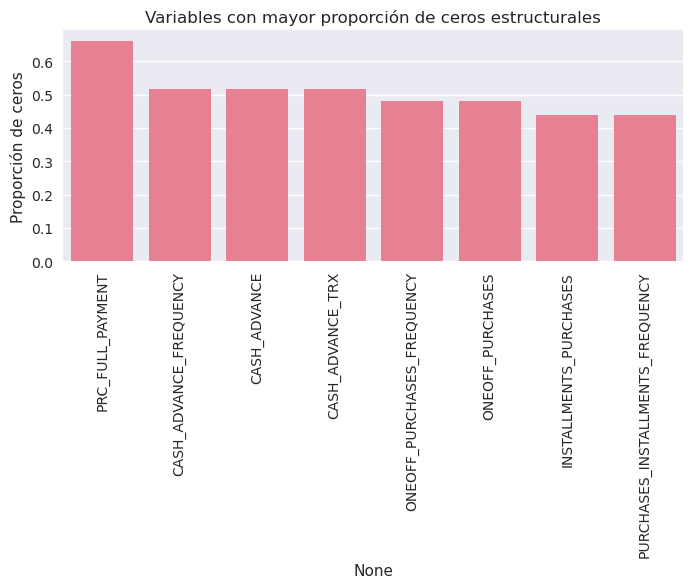

In [8]:
top_zeros = zero_ratio.head(8)

plt.figure(figsize=(8,3))
sns.barplot(x=top_zeros.index, y=top_zeros.values)
plt.xticks(rotation=90)
plt.ylabel("Proporción de ceros")
plt.title("Variables con mayor proporción de ceros estructurales")
plt.show()

El análisis de la proporción de valores exactamente iguales a cero revela que varias variables presentan una alta concentración de ceros, lo cual no corresponde a valores perdidos sino a ausencia real de actividad financiera en determinados comportamientos. En particular:

- `PRC_FULL_PAYMENT` presenta un ~66% de ceros, indicando que la mayoría de clientes no paga el total del saldo en la mayoría de los meses.
- Las variables relacionadas con anticipos de efectivo (`CASH_ADVANCE`, `CASH_ADVANCE_TRX`, `CASH_ADVANCE_FREQUENCY`) muestran aproximadamente un 52% de ceros, lo que sugiere que más de la mitad de los clientes no utiliza este servicio.
- Las compras puntuales y a plazos (`ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`) también presentan proporciones elevadas (~44–48%), reflejando que muchos clientes no realizan ciertos tipos de transacciones.

**Implicaciones metodológicas**

Este patrón indica que el dataset contiene variables con distribuciones zero-inflated (infladas en cero), altamente asimétricas y con colas largas. Estas características tienen consecuencias directas:

1. No deben interpretarse como missing values, sino como comportamiento legítimo.
2. Pueden dominar medidas basadas en distancia (por ejemplo, K-Means), haciendo necesario aplicar:

    - Escalado robusto
    - Transformaciones logarítmicas
    - Métodos menos sensibles a ceros masivos.
3. La presencia de ceros estructurales es relevante para segmentación, ya que separa naturalmente perfiles de clientes activos frente a inactivos en ciertas categorías.

En conjunto, la elevada proporción de ceros refleja una fuerte heterogeneidad en los patrones de consumo, anticipando la existencia de grupos diferenciados de clientes, lo que justifica el uso posterior de técnicas de clustering.

### 3.4 Distribuciones y asimetría de las variables

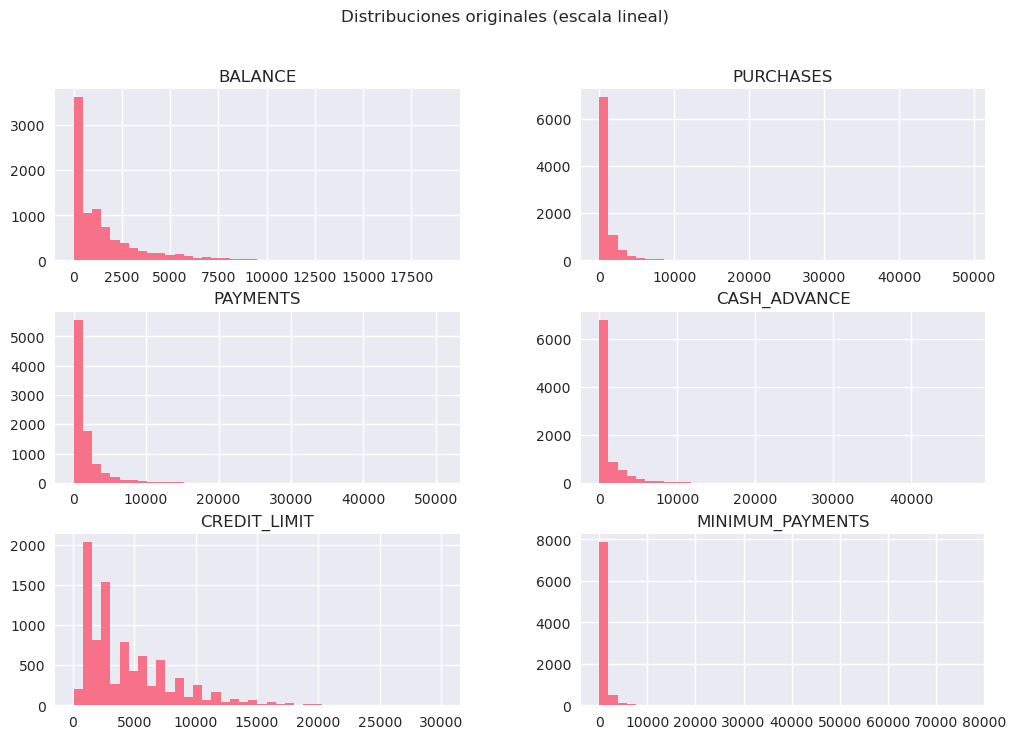

In [9]:
# Variables monetarias principales
money_vars = [
    "BALANCE", "PURCHASES", "PAYMENTS",
    "CASH_ADVANCE", "CREDIT_LIMIT", "MINIMUM_PAYMENTS"
]

df[money_vars].hist(bins=40, figsize=(12,8))
plt.suptitle("Distribuciones originales (escala lineal)")
plt.show()

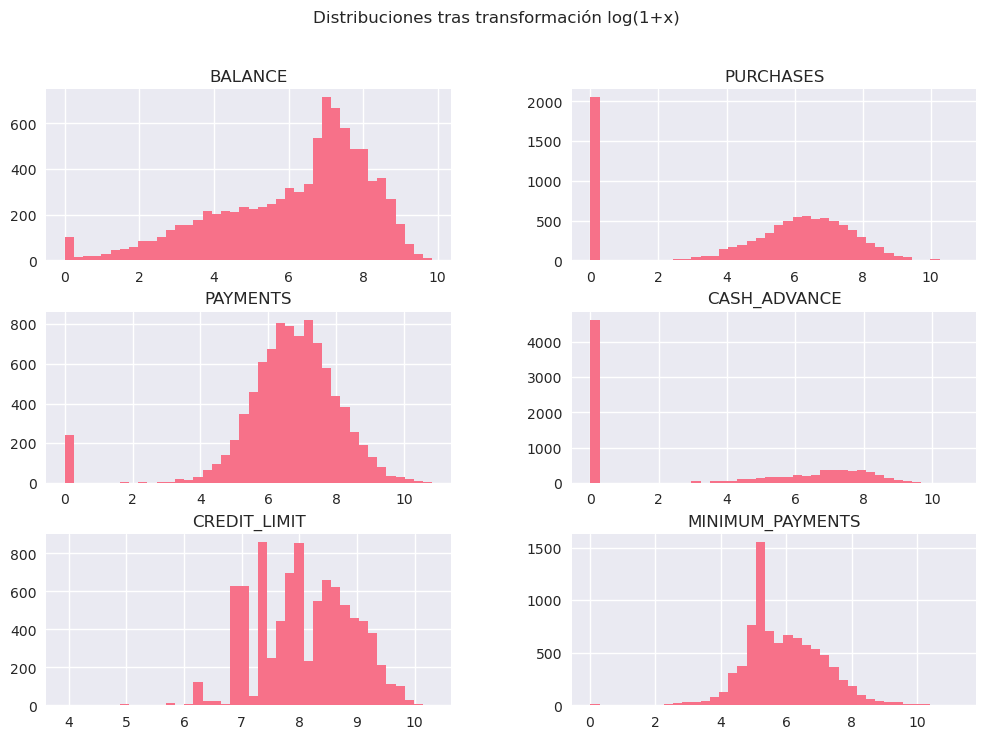

In [10]:
df_log = df[money_vars].apply(lambda x: np.log1p(x))

df_log.hist(bins=40, figsize=(12,8))
plt.suptitle("Distribuciones tras transformación log(1+x)")
plt.show()

Las principales variables monetarias del dataset (`BALANCE`, `PURCHASES`, `PAYMENTS`, `CASH_ADVANCE`, `CREDIT_LIMIT`, `MINIMUM_PAYMENTS`) presentan distribuciones fuertemente asimétricas hacia la derecha en escala lineal. En todos los casos se observa una alta concentración de clientes con valores bajos o moderados, junto con una cola larga de observaciones extremas asociadas a perfiles de alto gasto o elevado uso del crédito. 

Este patrón implica que la media y la varianza están dominadas por unos pocos valores grandes, lo que puede afectar negativamente a algoritmos basados en distancias (como k-means), ya que los outliers tienden a distorsionar la estructura geométrica del espacio de características.

Para mitigar este efecto, se aplica una transformación logarítmica suave mediante *log(1+x)*, que comprime la escala de los valores altos y reduce la asimetría. Tras la transformación, las distribuciones se vuelven más equilibradas y comparables entre variables, facilitando tanto la estandarización como la posterior identificación de patrones de segmentación.

Además, algunas variables como `CASH_ADVANCE` mantienen un pico significativo en cero incluso tras la transformación, lo que sugiere un comportamiento estructural (clientes que nunca utilizan anticipos de efectivo), y no simplemente valores bajos.

En consecuencia, este análisis justifica el uso de transformaciones no lineales y escalado robusto como paso previo al clustering.

### 3.5 Correlaciones y redundancia entre variables

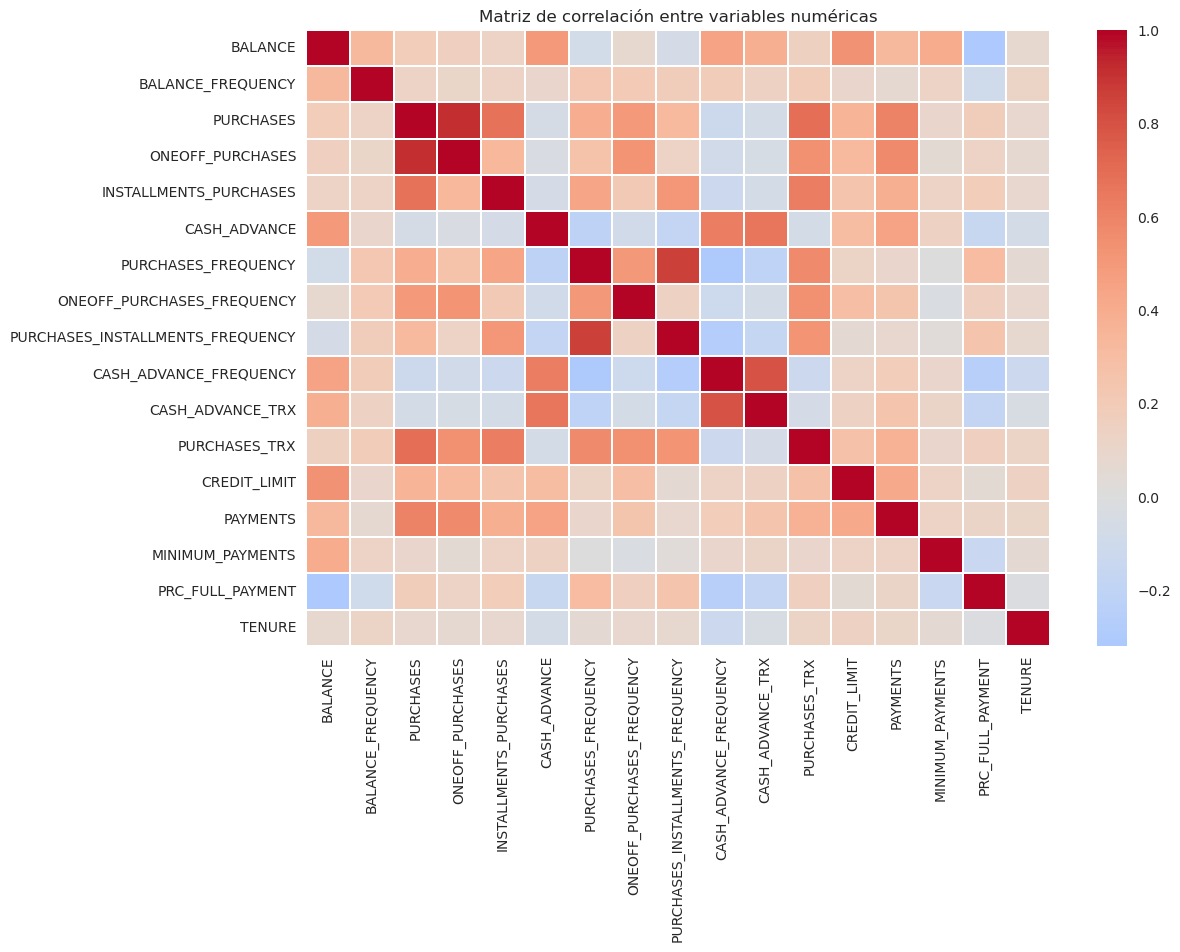

In [11]:
# Correlación
corr = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.3
)

plt.title("Matriz de correlación entre variables numéricas")
plt.show()

In [12]:
# Extraer pares con correlación alta
corr_pairs = (
    corr.abs()
    .unstack()
    .sort_values(ascending=False)
)

# Quitamos autocorrelaciones
corr_pairs = corr_pairs[corr_pairs < 1]

corr_pairs.head(10)

PURCHASES                         ONEOFF_PURCHASES                    0.916845
ONEOFF_PURCHASES                  PURCHASES                           0.916845
PURCHASES_INSTALLMENTS_FREQUENCY  PURCHASES_FREQUENCY                 0.862934
PURCHASES_FREQUENCY               PURCHASES_INSTALLMENTS_FREQUENCY    0.862934
CASH_ADVANCE_FREQUENCY            CASH_ADVANCE_TRX                    0.799561
CASH_ADVANCE_TRX                  CASH_ADVANCE_FREQUENCY              0.799561
PURCHASES_TRX                     PURCHASES                           0.689561
PURCHASES                         PURCHASES_TRX                       0.689561
INSTALLMENTS_PURCHASES            PURCHASES                           0.679896
PURCHASES                         INSTALLMENTS_PURCHASES              0.679896
dtype: float64

La matriz de correlación revela que el dataset contiene bloques claros de variables altamente dependientes, lo cual es esperable porque muchas métricas describen el mismo fenómeno financiero desde distintos ángulos (importe total, frecuencia y número de transacciones). En particular, destacan varias correlaciones fuertes:

- `PURCHASES` – `ONEOFF_PURCHASES` (ρ ≈ 0.92)
Esto indica que el volumen total de compras está dominado en muchos casos por compras puntuales, lo que introduce redundancia entre ambas variables.
- `PURCHASES_FREQUENCY` – `PURCHASES_INSTALLMENTS_FREQUENCY` (ρ ≈ 0.86)
Las frecuencias de compra general y a plazos evolucionan de forma muy similar, sugiriendo patrones de comportamiento consistentes en el uso del crédito.
- `CASH_ADVANCE_FREQUENCY` – `CASH_ADVANCE_TRX` (ρ ≈ 0.80)
La frecuencia de anticipos y el número de transacciones asociadas están estrechamente ligados, reflejando que ambas variables capturan prácticamente el mismo hábito.
- `PURCHASES` – `PURCHASES_TRX` (ρ ≈ 0.69)
El importe total y el número de compras tienden a crecer conjuntamente, aunque no de forma perfecta, lo que refleja heterogeneidad en el gasto medio por transacción.

En conjunto, estas dependencias sugieren que el espacio original presenta multicolinealidad y redundancia estructural, lo que justifica el uso posterior de:

- Reducción de dimensionalidad (PCA) para concentrar información.
- Métodos de clustering robustos a correlaciones.
- Escalado previo para evitar que variables repetidas dominen las distancias.

## **4. PREPROCESAMIENTO Y LIMPIEZA DE DATOS**

A partir del análisis exploratorio previo, se identifican varios aspectos que deben abordarse antes de aplicar técnicas de reducción de dimensionalidad y clustering:

- Presencia de valores faltantes en un pequeño subconjunto de variables monetarias.
- Distribuciones fuertemente asimétricas con colas largas y valores extremos.
- Escalas heterogéneas entre importes, frecuencias y recuentos.
- Redundancia parcial entre variables correlacionadas.

Por tanto, se define un pipeline de preprocesado que incluye:

1. Imputación robusta mediante mediana.
2. Transformación logarítmica en variables monetarias.
3. Escalado estándar para garantizar comparabilidad entre dimensiones.

In [13]:
# 1. Variables monetarias (asimétricas)
money_vars = ["BALANCE", "PURCHASES", "PAYMENTS", "CASH_ADVANCE", "CREDIT_LIMIT", "MINIMUM_PAYMENTS"]
other_vars = [c for c in df.columns if c not in money_vars and c != "CUST_ID"]

# 2. Transformación log(1+x) solo en monetarias
log1p = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

# 3. Pipeline preprocesamiento
preprocess = ColumnTransformer(
    transformers=[
        ("money", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("log", log1p),
            ("scaler", StandardScaler())
        ]), money_vars),

        ("rest", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), other_vars)
    ],
    remainder="drop"
)

X_prepared = preprocess.fit_transform(df)

X_prepared

array([[-1.20521818, -0.11353236, -0.82448405, ..., -0.51133325,
        -0.52555097,  0.36067954],
       [ 0.94891762, -1.67985462,  1.06503312, ..., -0.59179588,
         0.2342269 ,  0.36067954],
       [ 0.82499258,  0.60072652, -0.11929988, ..., -0.10902012,
        -0.52555097,  0.36067954],
       ...,
       [-1.4738341 ,  0.02737383, -1.39131795, ..., -0.39063931,
         0.32919999, -4.12276757],
       [-1.73377525, -1.67985462, -1.66109743, ..., -0.59179588,
         0.32919999, -4.12276757],
       [-0.11830096,  0.71936468, -1.54747543, ...,  0.33352433,
        -0.52555097, -4.12276757]], shape=(8950, 17))

El preprocesado se implementa mediante un ColumnTransformer, aplicando una transformación logarítmica únicamente sobre las variables monetarias (altamente asimétricas), mientras que el resto de variables se imputan y escalan directamente. Este enfoque permite preparar los datos de forma coherente antes de aplicar PCA, evitando sesgos por escala, valores extremos o datos incompletos.

## **5. Reducción de dimensionalidad mediante PCA**

Dado que el conjunto contiene variables correlacionadas y parcialmente redundantes, se aplica PCA para proyectar los datos en un espacio de menor dimensión preservando la mayor parte de la varianza.

### 5.1 PCA completo y varianza explicada

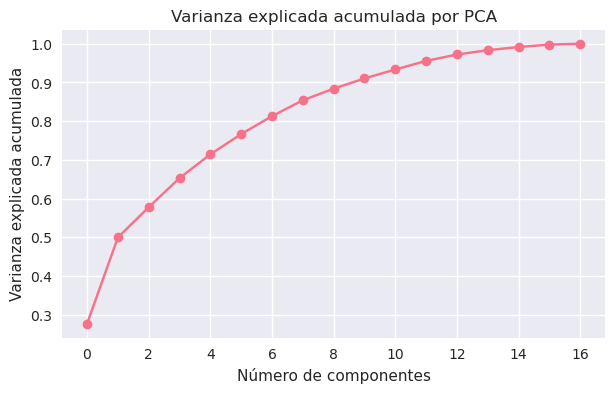

In [14]:
# Pipeline completo: preprocesado + PCA
pipe_pca = Pipeline([
    ("preprocess", preprocess),
    ("pca", PCA())
])

# Ajustamos PCA sobre todos los componentes
X_pca = pipe_pca.fit_transform(df)

# Extraemos varianza explicada acumulada
pca_model = pipe_pca.named_steps["pca"]
explained_var = np.cumsum(pca_model.explained_variance_ratio_)

# Gráfico
plt.figure(figsize=(7,4))
plt.plot(explained_var, marker="o")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Varianza explicada acumulada por PCA")
plt.grid(True)
plt.show()

La curva de varianza explicada acumulada indica que unas pocas componentes concentran gran parte de la información del conjunto. En particular, con aproximadamente 8 componentes se retiene más del 90% de la varianza, mientras que con 11 componentes se alcanza en torno al 95%. Por tanto, PCA permite reducir dimensionalidad de forma significativa sin pérdida relevante de información, lo que facilita el clustering en un espacio más compacto.

### 5.2 PCA reducido

In [15]:
pca_final = PCA(n_components=0.95)

pipe_reduced = Pipeline([
    ("preprocess", preprocess),
    ("pca", pca_final)
])

X_reduced = pipe_reduced.fit_transform(df)

X_reduced

array([[-0.77213648, -2.42771285,  0.69353602, ..., -0.11872442,
         0.02163786, -0.72467138],
       [-2.48991719,  1.53585115, -0.24213842, ..., -0.02621999,
        -0.00411527,  0.84512223],
       [ 1.47245861,  0.80859003,  0.44363477, ..., -0.49566942,
        -1.00594538, -0.16956967],
       ...,
       [ 0.30267771, -3.20763398, -0.40314967, ...,  0.17275308,
         0.45701924, -0.26903423],
       [-2.47946667, -3.35148089, -1.3096855 , ..., -0.52993258,
         0.06261899, -0.2594009 ],
       [-0.38890019, -1.12335854, -1.89296204, ..., -0.56488199,
        -0.694623  ,  0.08937501]], shape=(8950, 12))

Aplicando PCA con un umbral de varianza explicada del 95% (*n_components=0.95*), el conjunto queda representado mediante 12 componentes principales. Esto supone una reducción dimensional de 17 a 12 variables latentes, eliminando redundancia y colinealidad, pero preservando prácticamente toda la información estructural del dataset. Este espacio reducido resulta más adecuado para algoritmos de clustering, al disminuir ruido y mejorar la separabilidad entre perfiles de clientes.

## **6. MODELO BASELINE: KMEANS**

Una vez completado el preprocesado (imputación, transformación logarítmica, escalado y reducción dimensional mediante PCA), el dataset queda representado en un espacio numérico homogéneo y adecuado para aplicar algoritmos de agrupamiento. El objetivo de esta sección es identificar **segmentos de clientes con patrones de comportamiento financiero similares**, sin disponer de etiquetas previas (aprendizaje no supervisado).

Para estimar el número óptimo de clusters (k) en el algoritmo **K-Means**, se evaluarán distintos valores de \(k\) utilizando dos criterios complementarios:

- **Inercia (WCSS)**: mide la compacidad interna de los clusters. Valores menores indican grupos más concentrados, aunque siempre decrece al aumentar (k).
- **Silhouette score**: cuantifica simultáneamente la cohesión interna y la separación entre clusters. Valores más altos indican una estructura de agrupamiento más consistente.

A partir de estas métricas, se seleccionará un valor de (k) que represente un equilibrio entre simplicidad e interpretabilidad.

### 6.1 Selección del número óptimo de clusters

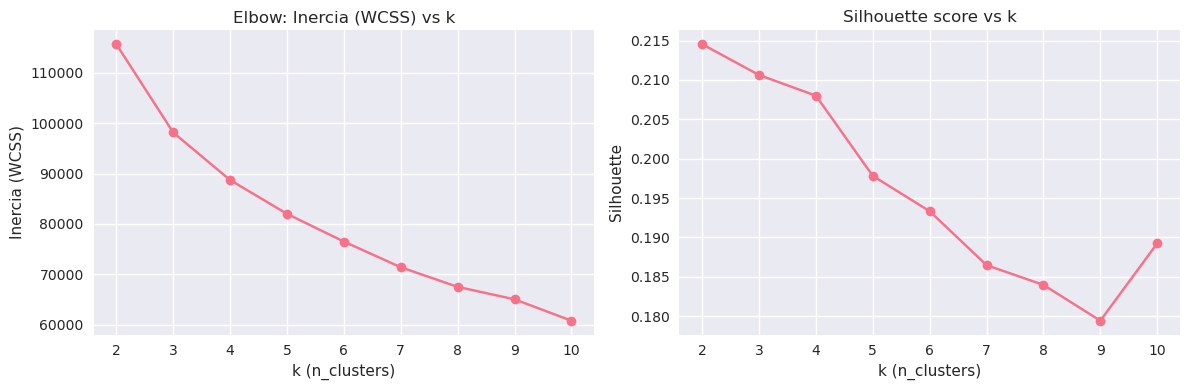

In [16]:
ks = range(2, 11)
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_reduced)

    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_reduced, labels))

ks_arr = np.array(list(ks))
inertias_arr = np.array(inertias, dtype=float)
sil_arr = np.array(sil_scores, dtype=float)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Elbow (Inercia)
ax[0].plot(ks_arr, inertias_arr, marker="o")
ax[0].set_title("Elbow: Inercia (WCSS) vs k")
ax[0].set_xlabel("k (n_clusters)")
ax[0].set_ylabel("Inercia (WCSS)")
ax[0].grid(True)

# Silhouette
ax[1].plot(ks_arr, sil_arr, marker="o")
ax[1].set_title("Silhouette score vs k")
ax[1].set_xlabel("k (n_clusters)")
ax[1].set_ylabel("Silhouette")
ax[1].grid(True)

plt.tight_layout()
plt.show()

En la figura anterior se observa que la **inercia (WCSS)** disminuye rápidamente entre *k=2* y *k=4*, lo que indica que pasar de pocos clusters a varios mejora notablemente la compacidad. Sin embargo, a partir de *k>=5* la reducción se vuelve progresivamente más marginal, sugiriendo una zona de “codo” alrededor de *k=4*.

Por otro lado, el **silhouette score** alcanza su valor máximo en *k=2 (≈0.215)* y tiene una fuerte caida en *k=5*, lo que parece indicar que *k=4* el el mejor valor a seleccionar. Cabe destacar que los valores de silhouette son moderados (<0.25), lo que sugiere que la estructura de clusters no es extremadamente marcada, algo habitual en datos financieros reales con transiciones suaves entre perfiles de clientes.


En conjunto, los resultados indican que:

- *k=2* proporciona la estructura más separable según silhouette, aunque puede ser demasiado simplista para segmentación.
- *k=4* ofrece un buen balance entre inercia y sihlouette, capturando mayor heterogeneidad sin perder completamente la coherencia de los grupos.

Por tanto, en los siguientes apartados se explorará la solución con *k=4* intermedio como punto de partida para la segmentación final.

###  6.2 Modelo final con *k=4*

In [17]:
# Modelo final con k óptimo
kmeans_final = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("kmeans", KMeans(n_clusters=4, random_state=42, n_init="auto"))
])

# Ajustamos sobre los datos reducidos
labels_final = kmeans_final.fit_predict(df)

df_labeled = df.copy()
df_labeled["cluster"] = labels_final
df_labeled[["cluster"]].value_counts().sort_index()

cluster
0          3400
1          1377
2          1175
3          2998
Name: count, dtype: int64

In [18]:
profile_median = df_labeled.groupby("cluster").median(numeric_only=True)
profile_median

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,462.993894,1.0,625.09,103.00,310.17,0.000000,0.833333,0.083333,0.666667,0.00,0.0,12.0,2500.0,705.837160,211.317636,0.0,12.0
1,20.122520,0.4,167.22,0.00,30.57,0.000000,0.250000,0.000000,0.083333,0.00,0.0,3.0,2500.0,301.678494,98.429502,0.0,12.0
2,1904.495561,1.0,3216.97,1933.93,1060.28,0.000000,1.000000,0.750000,0.916667,0.00,0.0,46.0,7500.0,3019.018390,573.258246,0.0,12.0
3,1819.188956,1.0,0.00,0.00,0.00,1497.377132,0.000000,0.000000,0.000000,0.25,5.0,0.0,3000.0,974.978188,618.220438,0.0,12.0


### 6.2 Visualización PCA

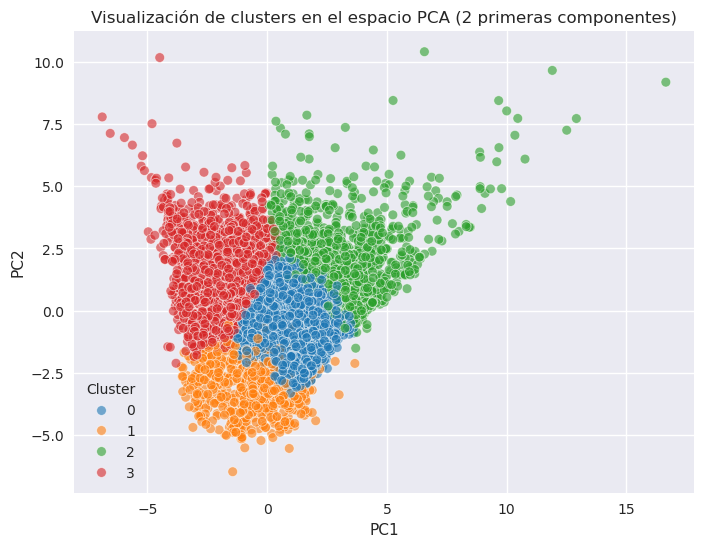

In [19]:
# Proyección en 2D usando las dos primeras componentes
X_2d = X_reduced[:, :2]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=labels_final,
    palette="tab10",
    alpha=0.6
)

plt.title("Visualización de clusters en el espacio PCA (2 primeras componentes)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

La proyección en dos dimensiones mediante las dos primeras componentes principales permite observar la estructura general de los grupos obtenidos por K-Means. En la figura se aprecia que los cuatro clusters ocupan regiones diferenciadas del plano (PC1, PC2), aunque con cierto solapamiento en la zona central, lo cual es esperable dado que:

- La separación real ocurre en un espacio de 12 dimensiones (tras PCA al 95%).
- La proyección a 2D solo captura una fracción de la varianza total.

Aun así, se identifican patrones claros:

- Un grupo desplazado hacia valores altos de PC1.
- Otro cluster más concentrado en valores negativos.
- Y dos grupos con distribución intermedia.

Esto sugiere que los segmentos capturan comportamientos de consumo distintos, aunque no perfectamente separables.

### 6.3 Visualización t-SNE

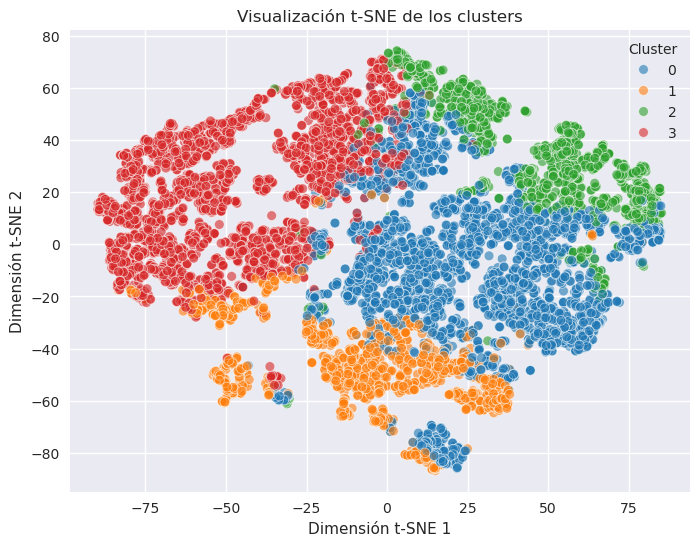

In [20]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init="pca"
)

X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(8,6))

sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=labels_final,
    palette="tab10",
    alpha=0.6
)

plt.title("Visualización t-SNE de los clusters")
plt.xlabel("Dimensión t-SNE 1")
plt.ylabel("Dimensión t-SNE 2")
plt.legend(title="Cluster")
plt.show()

Para complementar PCA, se aplica t-SNE, una técnica no lineal especialmente útil para visualizar estructuras locales en alta dimensión. En este caso, t-SNE muestra una separación más marcada entre clusters, con regiones relativamente compactas y mejor definidas. Esto refuerza la idea de que los clusters detectados por K-Means reflejan diferencias reales en los perfiles de clientes, aunque debe recordarse que:

- t-SNE es una herramienta exploratoria, no un método de validación formal.

- La geometría global del mapa no debe interpretarse como distancias exactas.

### 6.4 Tamaño de clusters

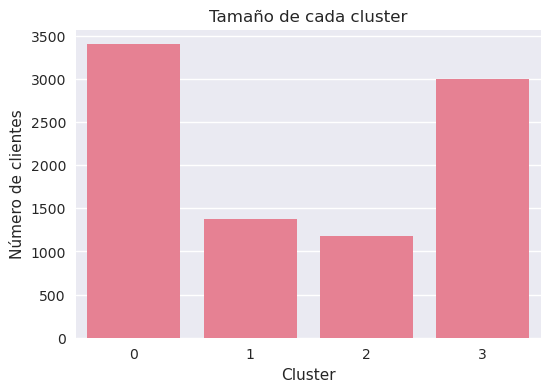

In [21]:
cluster_sizes = pd.Series(labels_final).value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)

plt.title("Tamaño de cada cluster")
plt.xlabel("Cluster")
plt.ylabel("Número de clientes")
plt.show()

El análisis de tamaños revela una distribución moderadamente equilibrada:

- Cluster 0: ~3400 clientes
- Cluster 3: ~3000 clientes
- Cluster 1: ~1400 clientes
- Cluster 2: ~1200 clientes

Esto indica que no se trata de una segmentación degenerada con clusters residuales muy pequeños, sino de grupos con suficiente representatividad para ser interpretables.

### 6.5 Perfil medio por cluster

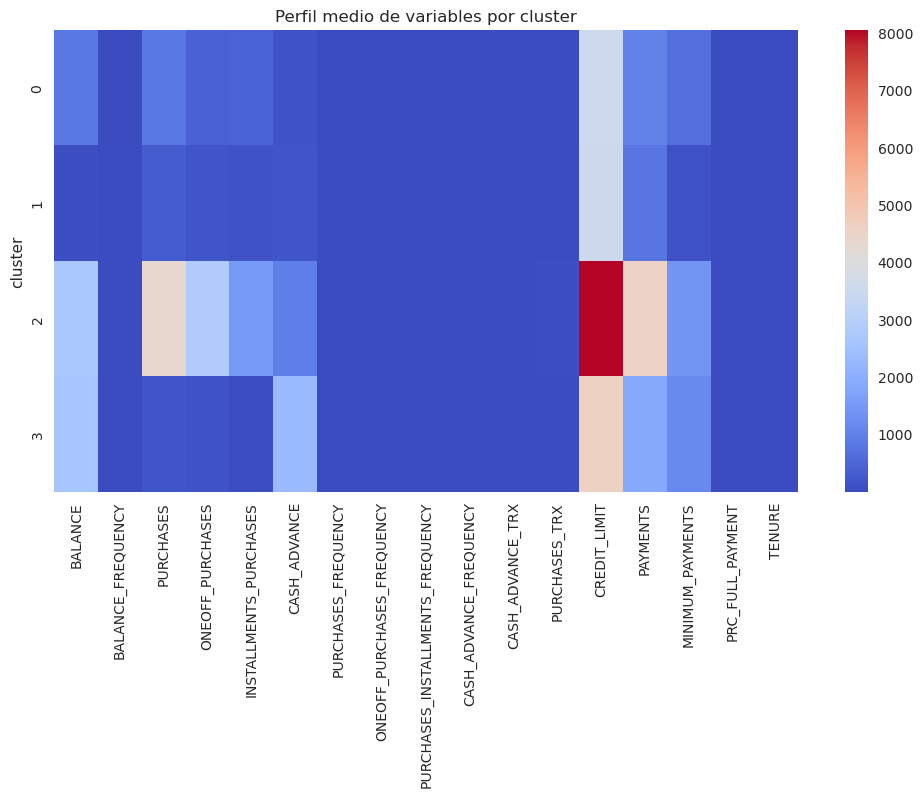

In [22]:
df_profiles = df.copy()
df_profiles["cluster"] = labels_final

cluster_means = df_profiles.groupby("cluster").mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means, cmap="coolwarm")

plt.title("Perfil medio de variables por cluster")
plt.show()

El mapa de calor de medias por cluster permite caracterizar los segmentos de forma directa:

- Cluster 2 destaca por valores elevados en `PURCHASES`, `CREDIT_LIMIT` y `PAYMENTS`, representando clientes con alto volumen de gasto y alta capacidad crediticia.
- Cluster 3 presenta valores altos en `CASH_ADVANCE` y frecuencia asociada, sugiriendo un perfil centrado en adelantos de efectivo más que en compras.
- Cluster 0 agrupa clientes con actividad moderada en compras y pagos, posiblemente un segmento estándar o medio.
- Cluster 1 muestra niveles bajos en casi todas las variables monetarias, reflejando usuarios con baja utilización del crédito.

Estos patrones permiten asignar significado económico a cada cluster, cumpliendo el objetivo principal de la segmentación.

### 6.6 Pairplot

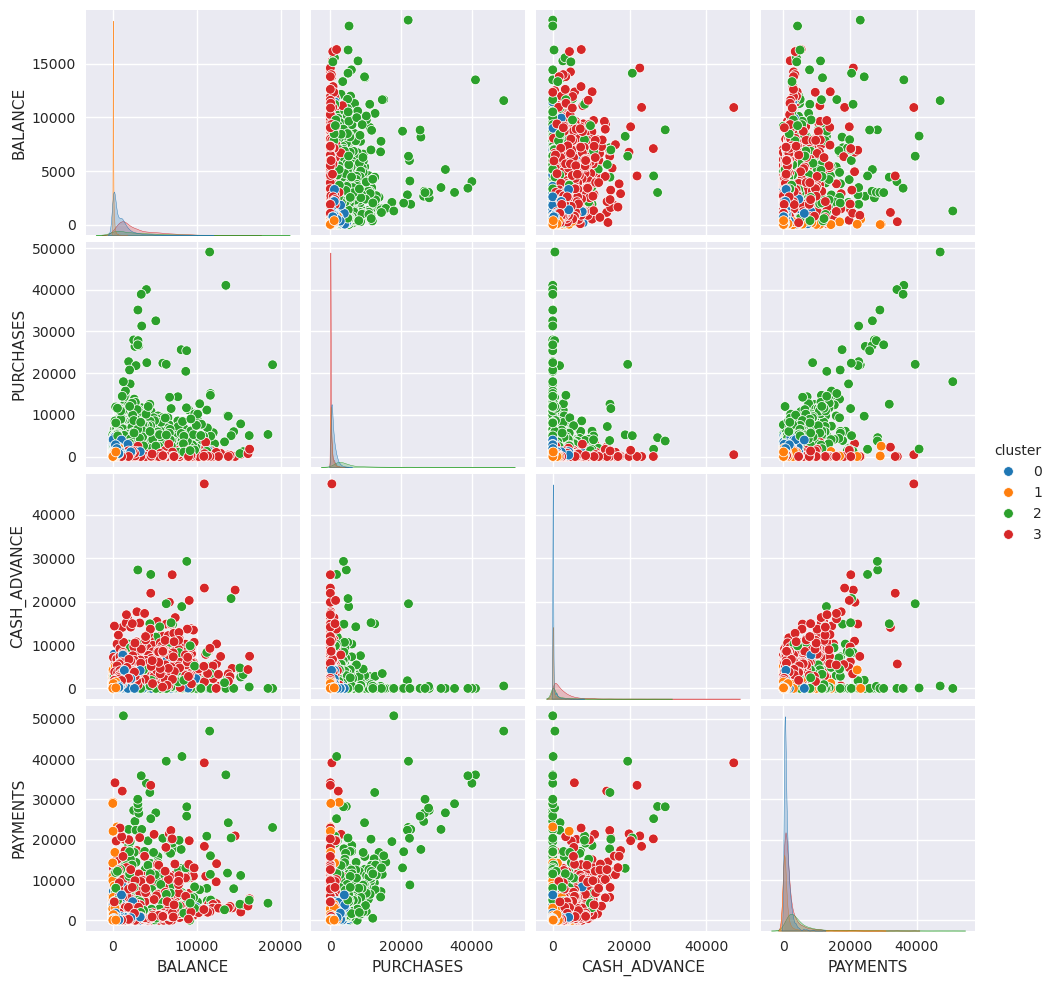

In [23]:
vars_plot = ["BALANCE", "PURCHASES", "CASH_ADVANCE", "PAYMENTS"]

sns.pairplot(
    df_profiles[vars_plot + ["cluster"]],
    hue="cluster",
    palette="tab10"
)
plt.show()

Finalmente, el pairplot entre variables monetarias principales (`BALANCE`, `PURCHASES`, `CASH_ADVANCE`, `PAYMENTS`) confirma visualmente la diferenciación:

- Los clientes del cluster de alto gasto aparecen concentrados en las zonas superiores.
- El cluster asociado a cash advance se separa claramente en esa dimensión.
- Mientras que los clusters de baja actividad permanecen cerca del origen.

Este análisis proporciona evidencia adicional de que la segmentación no es arbitraria, sino coherente con las variables originales.

### 6.7 Interpretación de los segmentos

**Cluster 0 — Clientes de uso moderado**

- Actividad media en compras y pagos.
- Balance relativamente bajo.
- Uso limitado del crédito, sin comportamientos extremos.

Representa el grupo “estándar”, clientes con utilización normal de la tarjeta.

**Cluster 1 — Clientes de baja actividad**

- Valores bajos en casi todas las variables monetarias.
- Pocas compras, pocos pagos y bajo balance.
- Bajo nivel de utilización del crédito.

Segmento de usuarios poco activos o con uso ocasional del servicio.

**Cluster 2 — Clientes de alto consumo y alto límite**

- Valores elevados en:

    - `PURCHASES`
    - `PAYMENTS`
    - `CREDIT_LIMIT`

- Alta frecuencia de compras.
- Perfil claramente asociado a gasto elevado.

Segmento de clientes intensivos, con alta capacidad crediticia y consumo frecuente.

**Cluster 3 — Usuarios centrados en adelantos de efectivo**

- `CASH_ADVANCE` y `CASH_ADVANCE_TRX` significativamente altos.
- Casi ausencia de compras (`PURCHASES ≈ 0`).
- Uso del crédito más orientado a liquidez inmediata.

Segmento de riesgo potencial, asociado a dependencia de adelantos de efectivo.

**Conclusión**

En resumen, el modelo de clustering permite identificar perfiles diferenciados de clientes:

- Usuarios inactivos.
- Clientes estándar.
- Grandes consumidores.
- Usuarios orientados a cash advance.

Esta segmentación constituye una base sólida para tareas posteriores como:

- Personalización de productos.
- Estrategias de retención.
- Detección de riesgo.
- Análisis de comportamiento financiero.

## **7. MODELO ALTERNATIVO: GAUSSIAN MIXTURE MODEL**

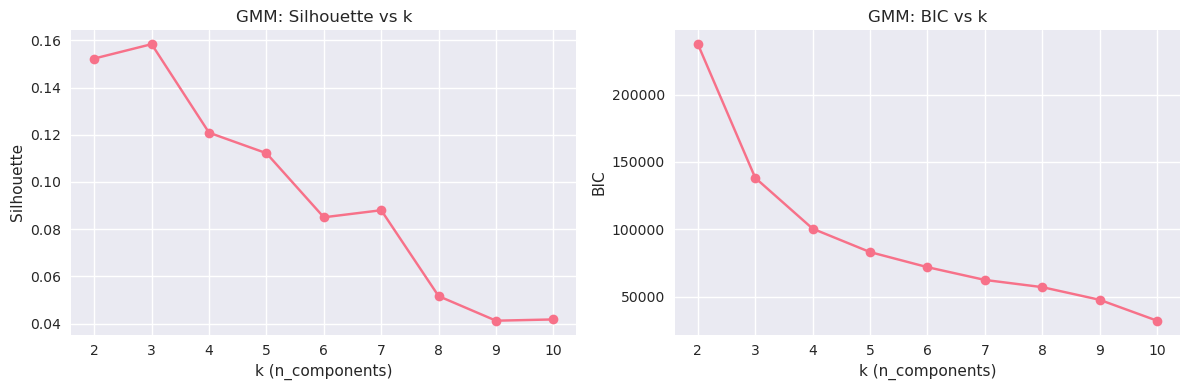

In [24]:
sil_gmm = []
bic_scores = []

for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels_gmm = gmm.fit_predict(X_reduced)

    sil_gmm.append(silhouette_score(X_reduced, labels_gmm))
    bic_scores.append(gmm.bic(X_reduced))

ks_arr = np.array(list(ks))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Silhouette
ax[0].plot(ks_arr, sil_gmm, marker="o")
ax[0].set_title("GMM: Silhouette vs k")
ax[0].set_xlabel("k (n_components)")
ax[0].set_ylabel("Silhouette")
ax[0].grid(True)

# BIC
ax[1].plot(ks_arr, bic_scores, marker="o")
ax[1].set_title("GMM: BIC vs k")
ax[1].set_xlabel("k (n_components)")
ax[1].set_ylabel("BIC")
ax[1].grid(True)

plt.tight_layout()
plt.show()

En esta sección se ha evaluado un modelo alternativo a K-Means, utilizando Gaussian Mixture Models (GMM). A diferencia de K-Means, que impone clusters esféricos, GMM permite modelar agrupaciones con formas elípticas y asignaciones probabilísticas, lo cual puede ser más flexible en datos reales. 

Para seleccionar el número óptimo de componentes k, se han comparado dos métricas complementarias:

1. Silhouette Score

En la gráfica de la izquierda se observa que:

- El valor máximo de silhouette se alcanza en k=3, con aproximadamente 0.16.
- A partir de k=4, el silhouette desciende de forma clara, indicando que la separación entre clusters se deteriora al aumentar la complejidad.
- Esto sugiere que, desde el punto de vista geométrico, 3 clusters proporcionan la estructura más coherente bajo GMM.

2. Bayesian Information Criterion (BIC)

En la gráfica de la derecha:

- De k=2 a k=3, el BIC cae de forma muy pronunciada.
- De k=3 a k=4, sigue bajando, pero ya con una pendiente mucho menor.
- A partir de k≥4, el descenso es progresivo y cada vez más suave.

Esto es exactamente lo que se interpreta como un “codo” en el BIC, por lo tanto 3 clusters parece ser el número óptimo.

### 7.1 Modelo final con k=3

In [25]:
gmm_final = Pipeline([
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("gmm", GaussianMixture(n_components=3, covariance_type="full", random_state=42))
])

# Fit del pipeline completo
gmm_final.fit(df)

# Etiquetas finales
labels_gmm = gmm_final.named_steps["gmm"].predict(
    gmm_final.named_steps["pca"].transform(
        gmm_final.named_steps["preprocess"].transform(df)
    )
)

df_labeled_gmm = df.copy()
df_labeled_gmm["cluster"] = labels_gmm
df_labeled_gmm[["cluster"]].value_counts().sort_index()

cluster
0          1991
1          4161
2          2798
Name: count, dtype: int64

In [26]:
profile_median_gmm = df_labeled_gmm.groupby("cluster").median(numeric_only=True)
profile_median_gmm

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,1472.378275,1.0,0.00,0.00,0.00,1193.999651,0.000000,0.000000,0.000000,0.250000,4.0,0.0,3000.0,744.908950,492.497922,0.0,12.0
1,151.787402,1.0,508.56,84.00,228.00,0.000000,0.666667,0.083333,0.454545,0.000000,0.0,10.0,3000.0,607.575208,177.486834,0.0,12.0
2,1688.390639,1.0,804.32,356.52,233.31,879.456980,0.666667,0.166667,0.416667,0.166667,3.0,12.0,4500.0,1625.496702,634.388953,0.0,12.0


### 7.1 Visualización PCA

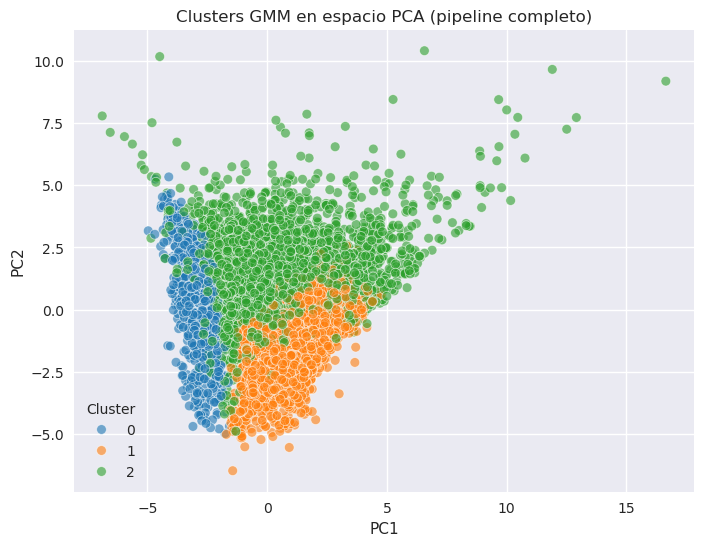

In [27]:
X_pca_gmm = gmm_final.named_steps["pca"].transform(
    gmm_final.named_steps["preprocess"].transform(df)
)

X_2d_gmm = X_pca_gmm[:, :2]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_2d_gmm[:,0],
    y=X_2d_gmm[:,1],
    hue=labels_gmm,
    palette="tab10",
    alpha=0.6
)
plt.title("Clusters GMM en espacio PCA (pipeline completo)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

La proyección sobre las dos primeras componentes principales muestra:

- Tres regiones claramente diferenciadas
- Cierto solapamiento entre grupos (esperable en GMM)

Esto confirma que el modelo captura estructuras más flexibles que K-Means.

### 7.3 Visualización t-SNE

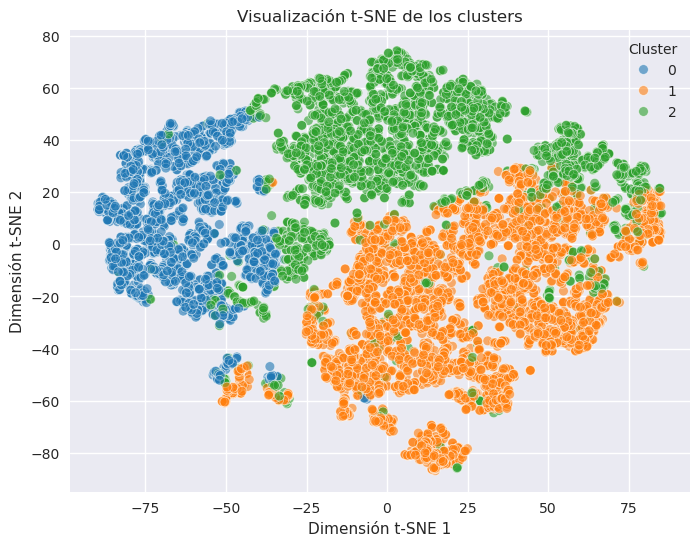

In [28]:
X_tsne_gmm = tsne.fit_transform(X_pca_gmm)

plt.figure(figsize=(8,6))

sns.scatterplot(
    x=X_tsne_gmm[:,0],
    y=X_tsne_gmm[:,1],
    hue=labels_gmm,
    palette="tab10",
    alpha=0.6
)

plt.title("Visualización t-SNE de los clusters")
plt.xlabel("Dimensión t-SNE 1")
plt.ylabel("Dimensión t-SNE 2")
plt.legend(title="Cluster")
plt.show()

El embedding no lineal mediante t-SNE refuerza la separación:

- Los clusters aparecen más compactos
- Se observa mejor la estructura interna de los datos

Dado que t-SNE preserva relaciones locales, esta visualización es especialmente útil para validar la segmentación obtenida.

### 7.4 Tamaño de clusters

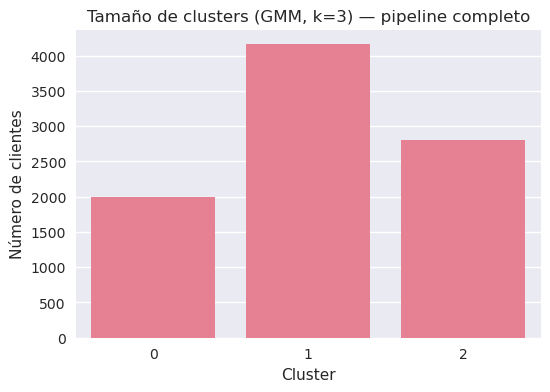

In [29]:
gmm_sizes = pd.Series(labels_gmm).value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=gmm_sizes.index, y=gmm_sizes.values)
plt.title("Tamaño de clusters (GMM, k=3) — pipeline completo")
plt.xlabel("Cluster")
plt.ylabel("Número de clientes")
plt.show()

El reparto de clientes es relativamente equilibrado:

- Un cluster dominante (~4200 clientes)
- Dos clusters menores (~2000–2800)

No se detectan clusters residuales extremadamente pequeños, lo cual sugiere que el modelo no está creando grupos artificiales.

### 7.5 Perfil medio por cluster

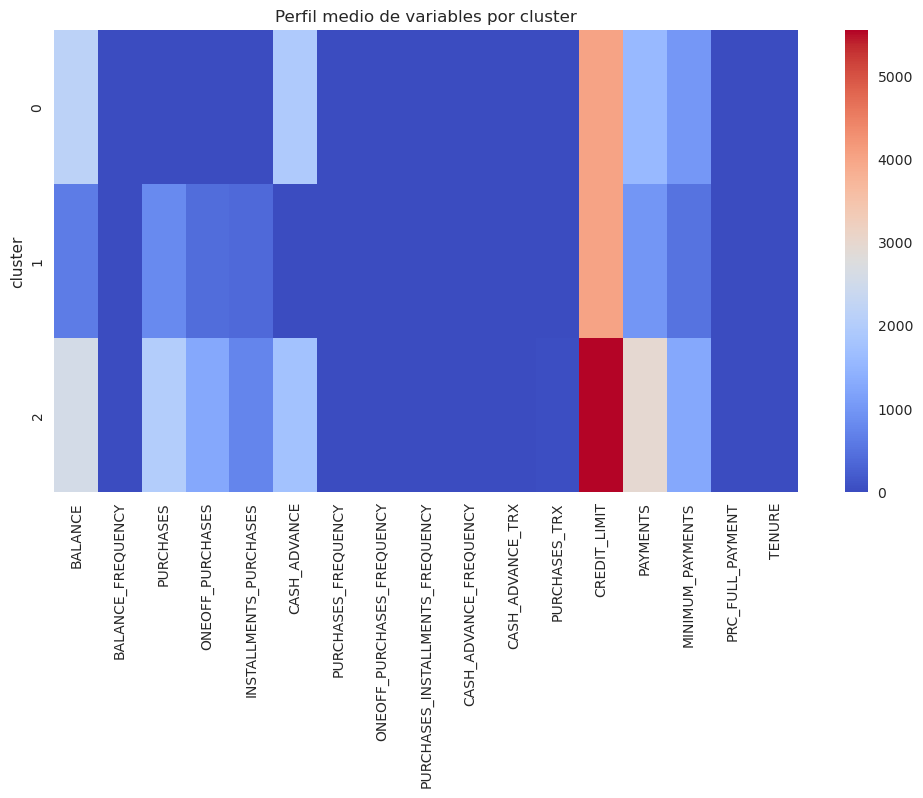

In [30]:
df_profiles_gmm = df.copy()
df_profiles_gmm["cluster"] = labels_gmm

cluster_means_gmm = df_profiles_gmm.groupby("cluster").mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means_gmm, cmap="coolwarm")

plt.title("Perfil medio de variables por cluster")
plt.show()

El heatmap permite interpretar los segmentos:

- Un grupo con mayor `CREDIT_LIMIT`
- Otro con mayor actividad en `PURCHASES`
- Un tercero con patrones intermedios o de menor uso

Esto evidencia que GMM produce clusters interpretables y coherentes en términos financieros.

### 7.6 Pairplot

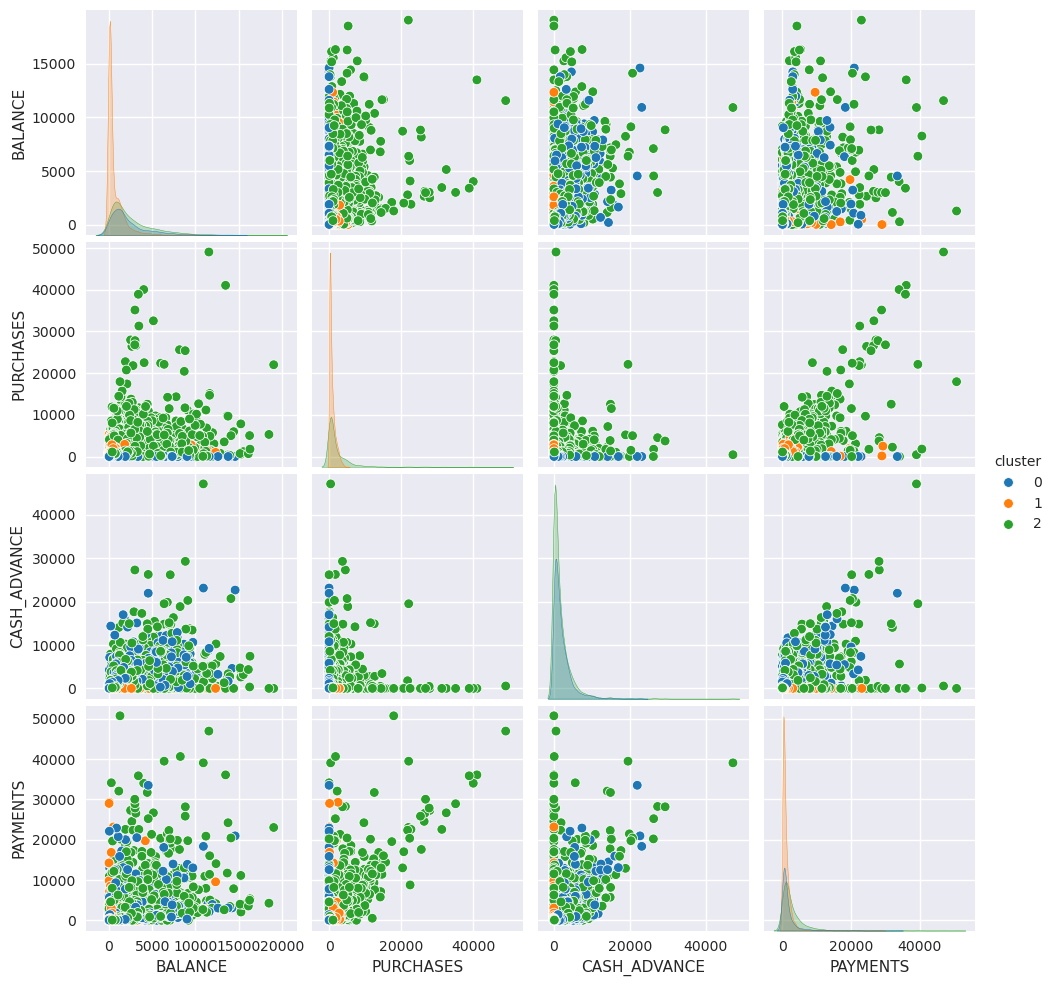

In [31]:
sns.pairplot(
    df_profiles_gmm[vars_plot + ["cluster"]],
    hue="cluster",
    palette="tab10"
)
plt.show()

### 7.7 Interpretación de los segmentos

**Cluster 0 — Clientes de perfil moderado y uso controlado**

Características:

- `BALANCE` medio
- `PURCHASES` moderadas
- `CASH_ADVANCE` prácticamente nulo
- `PAYMENTS` consistentes

Este grupo representa usuarios que utilizan la tarjeta principalmente para compras regulares, con un comportamiento estable y bajo riesgo.

**Cluster 1 — Clientes de baja actividad**

Características:

- `BALANCE` bajo
- `PURCHASES` reducidas
- `PAYMENTS` mínimos

Muy poca frecuencia de transacciones. Clientes con uso esporádico de la tarjeta o perfiles inactivos. Segmento relevante para estrategias de reactivación.

**Cluster 2 — Clientes de alto consumo y mayor capacidad crediticia**

Características:

- `PURCHASES` muy elevadas
- `CREDIT_LIMIT` claramente superior
- `PAYMENTS` altos
- Actividad frecuente

Usuarios intensivos, probablemente clientes premium o con alta capacidad adquisitiva. Segmento estratégico para programas de fidelización.

**Conclusión**

El modelo GMM permite identificar tres perfiles bien diferenciados:

- Usuarios moderados
- Usuarios inactivos
- Usuarios intensivos/premium

El pairplot refuerza que estas diferencias son observables directamente en las variables financieras originales, aumentando la interpretabilidad del clustering. Estos segmentos pueden ser utilizados para diseñar estrategias diferenciadas de marketing, control de riesgo y personalización de productos financieros.

## **8. MODELO FINAL**

En esta sección se selecciona el modelo definitivo de segmentaciónEn esta sección se selecciona el modelo definitivo de segmentación y se guarda para su reutilización futura.

### 8.1 Selección del modelo definitivo

Durante el análisis se han evaluado dos enfoques principales:

- K-Means, con selección óptima alrededor de *k=4*.
- Gaussian Mixture Model (GMM), con evidencia de mejor ajuste en *k=3*.

La comparación se ha basado en:

- Silhouette Score (separación entre clusters).
- BIC (criterio penalizado de ajuste probabilístico).
- Interpretabilidad de los segmentos obtenidos.

En particular:

- GMM permite clusters elípticos y de distinta densidad, más realista en datos financieros.
- El BIC muestra una caída brusca hasta k=3, sugiriendo que tres segmentos capturan la estructura principal.
- Los perfiles medios obtenidos con GMM son más compactos y diferenciables.

Por tanto, se selecciona **GMM** como modelo final.

### 8.2 Serialización del modelo

In [32]:
gmm_final

# Guardar pipeline completo
joblib.dump(gmm_final, "../results/final_customer_segmentation_pipeline.pkl")

['../results/final_customer_segmentation_pipeline.pkl']